In [2]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils


In [3]:
hdl_mc = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/MC_train_112361_LHC22b1b/LcSignal.root", "LcSignal")
hdl_totalBkg = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/MC_train_112361_LHC22b1b/LcBkg_small.root", "LcBkg")
print('MC: ',len(hdl_mc), ' | Bkg: ',len(hdl_totalBkg), ' | S/B: ', round(len(hdl_mc)/len(hdl_totalBkg),3))

# this is the fraction of data you want to take from the hdl_totalBkg daraframe

fractionBkg=1

hdl_totalBkg.shuffle_data_frame(frac=fractionBkg, inplace=True)


# ---------------------------------------------
# split the MC sample

hdl_mc_1=hdl_mc
hdl_mc_2=hdl_mc

dfmc=hdl_mc.get_data_frame()
dfmc=dfmc.query('fM > 2.2 & fM <2.4')

np.random.seed(42)

num_rows = dfmc.shape[0]
split_ratio = 0.4  # Adjust the ratio as needed
entries_sample_1 = int(num_rows * split_ratio)

indices_sample_1 = np.random.choice(num_rows, entries_sample_1, replace=False)
indices_sample_2 = np.setdiff1d(np.arange(num_rows), indices_sample_1)
df_sample_1 = dfmc.iloc[indices_sample_1]
df_sample_2 = dfmc.iloc[indices_sample_2]

#----------------------------------------
# split the data sample
hdl_data_1=hdl_totalBkg
hdl_data_2=hdl_totalBkg

hdl_totalSample_2=hdl_totalBkg

dfData=hdl_totalBkg.get_data_frame()
dfData.query('fM > 2.2 & fM <2.4',inplace=True)

np.random.seed(42)

num_rows_data = dfData.shape[0]
split_ratio = 0.4  # Adjust the ratio as needed
entries_sample_1 = int(num_rows_data * split_ratio)

indices_sample_1 = np.random.choice(num_rows_data, entries_sample_1, replace=False)
indices_sample_2 = np.setdiff1d(np.arange(num_rows_data), indices_sample_1)
dfData_sample_1 = dfData.iloc[indices_sample_1]
dfData_sample_2 = dfData.iloc[indices_sample_2]

#----------------------------------------

hdl_mc_1.set_data_frame(df_sample_1)
hdl_mc_2.set_data_frame(df_sample_2)

hdl_data_1.set_data_frame(dfData_sample_1)
hdl_data_2.set_data_frame(dfData_sample_2)

# hdl_data = TreeHandler("/eos/user/h/hsharma/XicMLTrees/DATA/XicBkg.root", "XicBkg")
# hdl_bkg = hdl_data.apply_preselections("fM < 2.42 or fM > 2.5", inplace=False)
# print('Size of samples \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))
# print('----------------------------------')



# # Samples for training
# fractionData=0.01 # this is the fraction of total data used in training 
# hdl_bkg.shuffle_data_frame(frac=fractionData, inplace=True)
# print('Size of samples for training \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))

MC:  78284  | Bkg:  4704137  | S/B:  0.017


In [10]:
sample1_ratio = round(df_sample_1.shape[0]/dfData_sample_1.shape[0], 3)
sample2_ratio = round(df_sample_2.shape[0]/dfData_sample_2.shape[0], 3)

print("type \t| sample 1 \t| sample 2 \t| mc/data ratio")
print("----------------------------------------------------")
print("MC \t| " ,df_sample_1.shape[0], " \t| ", df_sample_2.shape[0], " \t| ", sample1_ratio)
print("Data \t| " ,dfData_sample_1.shape[0], " \t| ", dfData_sample_2.shape[0], " \t| ", sample2_ratio)

type 	| sample 1 	| sample 2 	| mc/data ratio
----------------------------------------------------
MC 	|  31199  	|  46799  	|  0.017
Data 	|  1881654  	|  2822483  	|  0.017


In [5]:
df_application=dfmc

df_application.dropna(axis=0, inplace=True)
# from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=0, n_init="auto")
X = df_application.values
kmeans_model.fit(X)

KMeans(n_clusters=3, n_init='auto', random_state=0)

<Axes: >

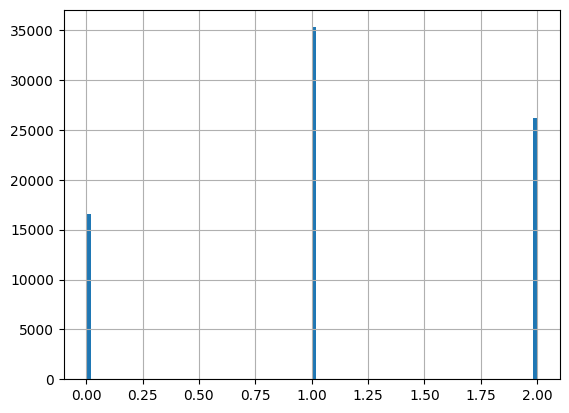

In [6]:
# Retrieve cluster labels
cluster_labels = kmeans_model.labels_

# Add cluster labels to the DataFrame
df_application['cluster'] = cluster_labels
df_application['cluster'].hist(bins=100)

<Axes: >

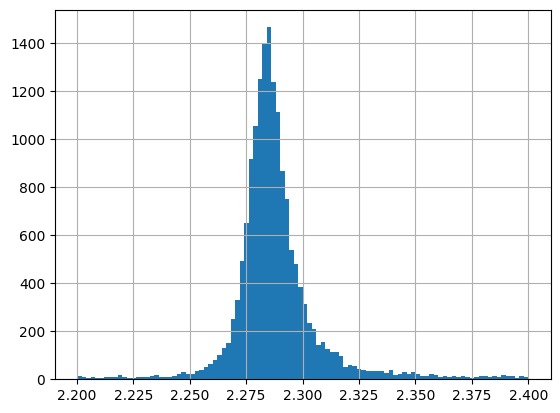

In [7]:
df_application.query('cluster==0')['fM'].hist(bins=100)


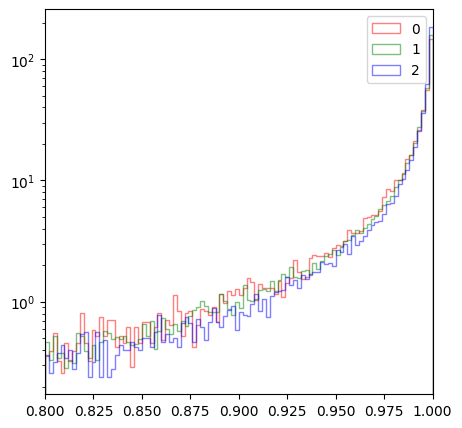

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

df_0 = df_application.query('cluster == 0')
df_1 = df_application.query('cluster == 1')
df_2 = df_application.query('cluster == 2')

plt.figure(figsize=(5, 5))

histrange=(0.8,1)
var='fCpa'
plt.hist(df_0[var], bins=100, log=1, density=1, alpha=0.5, range=histrange ,label='0',color='r',histtype='step')  # Adjust the number of bins as needed
plt.hist(df_1[var], bins=100, log=1, density=1, alpha=0.5 , range=histrange, label='1',color='g',histtype='step')  # Adjust the number of bins as needed
plt.hist(df_2[var], bins=100, log=1, density=1, alpha=0.5 ,range=histrange, label='2',color='b',histtype='step')  # Adjust the number of bins as needed
plt.xlim(histrange)
plt.legend()
plt.show()


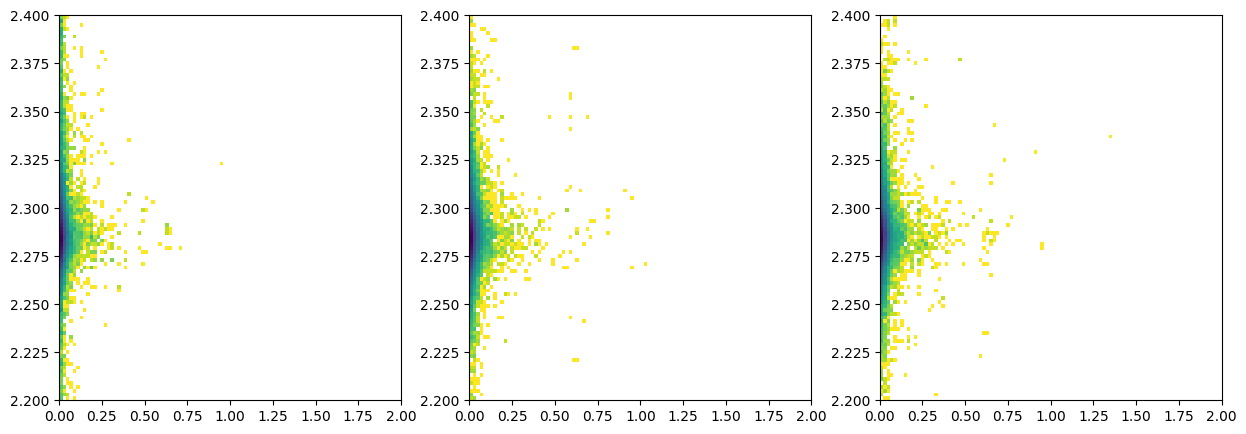

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x_min=0
x_max=2
y_min=2.2
y_max=2.4


var1='fDecayLengthXY'

# Create histograms with shared x-axis limits
for ax, df in zip(axes, [df_0, df_1, df_2]):
    h = ax.hist2d(df[var1], df['fM'], range=[[x_min, x_max],[y_min, y_max]],norm=mpl.colors.LogNorm(), bins=100, cmap='viridis_r')
    ax.set_xlim(x_min,x_max)  # Set custom x-axis limits


In [44]:
## Now we can try to fit the invariant mass spectrum

In [48]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 1.673, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.legend()
    plt.xlabel('$M_{\Lambda\pi}$ $(\mathrm{GeV/}\it{c}^2)$')
    plt.ylabel('Counts')
    plt.show()


In [49]:
fit_invmass(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], fit_range=[1.660, 1.685])

KeyError: 'mass'

In [ ]:
### you can also use some packages for implementing ROOT like plots in python
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [ ]:
fit_invmass(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [ ]:
#### reset matplotlib style if needed
plt.style.use('default')